In [13]:
# ============================================
# FULL SELF-CONTAINED EVALUATION SCRIPT
# ============================================

import cv2
import numpy as np
from pathlib import Path
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage.segmentation import watershed

# --------------------------------------------
# 1. Image loader
# --------------------------------------------
def load_image_any(src):
    """
    Simple safe loader.

    Accepts:
    - numpy array (returned as-is)
    - string path
    - Path object
    """
    if isinstance(src, np.ndarray):
        if src.size == 0:
            raise ValueError("Received an empty image array.")
        return src

    p = Path(src)
    if not p.exists():
        raise FileNotFoundError(f"Image not found: {p.resolve()}")

    img = cv2.imread(str(p), cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError(f"Could not read image: {p.resolve()}")
    return img


# --------------------------------------------
# 2. Segmentation functions (your original logic)
# --------------------------------------------
def segment_green_bg(img_bgr):
    """
    Green background:
    - grayscale
    - Gaussian blur subtraction (illumination correction)
    - CLAHE
    - Otsu threshold
    - morphological opening
    """
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    bg_blur = cv2.GaussianBlur(gray, (0, 0), sigmaX=35, sigmaY=35)
    detrended = cv2.subtract(gray, bg_blur)
    detrended_norm = cv2.normalize(detrended, None, 0, 255, cv2.NORM_MINMAX)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(detrended_norm)

    _, mask = cv2.threshold(
        enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)
    return mask


def segment_blue_bg(img_bgr):
    """
    Blue background:
    - HSV
    - dark pellets (low V)
    - light nurdles (low S + high V)
    - pick the mask with more pixels
    - morphological opening
    """
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

    # dark pellets: almost black
    dark_mask = cv2.inRange(
        hsv,
        np.array([0, 0, 0]),
        np.array([180, 255, 90])
    )

    # light nurdles: low saturation, high brightness
    light_mask = cv2.inRange(
        hsv,
        np.array([0, 0, 100]),
        np.array([180, 120, 255])
    )

    if np.sum(dark_mask) > np.sum(light_mask):
        mask_particles = dark_mask
    else:
        mask_particles = light_mask

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    mask_particles = cv2.morphologyEx(
        mask_particles, cv2.MORPH_OPEN, kernel, iterations=2
    )
    return mask_particles


def segment_white_bg(img_bgr):
    """
    White background:
    - grayscale
    - Gaussian blur
    - inverted Otsu threshold
    - morphological opening
    """
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    _, mask = cv2.threshold(
        blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
    )
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)
    return mask


# --------------------------------------------
# 3. Watershed splitting
# --------------------------------------------
def split_touching_particles(binary_mask, min_dist=8):
    """
    - binary mask -> distance transform
    - local maxima as seeds
    - watershed on -distance
    """
    bin_mask = (binary_mask > 0).astype(np.uint8)
    dist = cv2.distanceTransform(bin_mask, cv2.DIST_L2, 5)

    coords = peak_local_max(dist, min_distance=min_dist, labels=bin_mask)
    mask = np.zeros(dist.shape, dtype=bool)
    if coords.size > 0:
        mask[tuple(coords.T)] = True

    markers, _ = ndi.label(mask)
    labels = watershed(-dist, markers, mask=bin_mask)
    return labels, dist


# --------------------------------------------
# 4. True count from filename
# --------------------------------------------
def get_true_count_from_filename(img_path: Path) -> int:
    """
    '180_nurdles.png' -> 180
    """
    stem = img_path.stem
    first_part = stem.split("_")[0]
    return int(first_part)


# --------------------------------------------
# 5. Tuned background detection (your best ranges)
# --------------------------------------------
def detect_background_color_fixed(img_bgr):
    """
    Uses tuned HSV thresholds:
      green hue in [20, 70]
      blue  hue in [100, 160]
      white if median(S) < 50 and median(V) > 200
    """
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    h = hsv[:, :, 0].astype(np.float32)
    s = hsv[:, :, 1].astype(np.float32)
    v = hsv[:, :, 2].astype(np.float32)

    med_h = np.median(h)
    med_s = np.median(s)
    med_v = np.median(v)

    green_range = (20, 70)
    blue_range  = (100, 160)
    white_s_max = 50
    white_v_min = 200

    if green_range[0] <= med_h <= green_range[1]:
        return "green"
    elif blue_range[0] <= med_h <= blue_range[1]:
        return "blue"
    elif med_s < white_s_max and med_v > white_v_min:
        return "white"
    else:
        return "unknown"


# --------------------------------------------
# 6. Full pipeline for one image (returns count)
# --------------------------------------------
def process_image_count_only_fixed(
    img_path: Path,
    min_dist=8,
    min_area=50,
    max_area=2000,
    fallback_min_fg_pixels=100,
) -> int:
    img = load_image_any(img_path)

    # Background type using tuned HSV ranges
    bg_type = detect_background_color_fixed(img)

    # Background-specific segmentation
    if bg_type == "green":
        mask = segment_green_bg(img)
    elif bg_type == "blue":
        mask = segment_blue_bg(img)
    elif bg_type == "white":
        mask = segment_white_bg(img)
    else:
        # fallback: try green, then blue if almost nothing
        mask = segment_green_bg(img)
        if np.sum(mask > 0) < fallback_min_fg_pixels:
            mask = segment_blue_bg(img)

    # Watershed splitting
    labels, dist = split_touching_particles(mask, min_dist=min_dist)

    # Size filtering and counting
    filtered_labels = np.zeros_like(labels, dtype=np.int32)
    num_labels = int(labels.max())
    for lbl in range(1, num_labels + 1):
        area = np.sum(labels == lbl)
        if min_area <= area <= max_area:
            filtered_labels[labels == lbl] = lbl

    particle_ids = np.unique(filtered_labels[filtered_labels > 0])
    return len(particle_ids)


# --------------------------------------------
# 7. Evaluate MAE / MAPE on full dataset folder
# --------------------------------------------
image_extensions = {".jpg", ".jpeg", ".png", ".tif", ".tiff"}

def evaluate_dataset_counts(dataset_dir: str):
    folder = Path(dataset_dir)

    abs_errors = []
    abs_percent_errors = []

    for img_path in sorted(folder.iterdir()):
        if img_path.suffix.lower() not in image_extensions:
            continue

        true_count = get_true_count_from_filename(img_path)
        pred_count = process_image_count_only_fixed(img_path)

        err = abs(pred_count - true_count)
        abs_errors.append(err)
        if true_count > 0:
            abs_percent_errors.append(err / true_count * 100.0)

        print(f"{img_path.name}: true={true_count}, pred={pred_count}, "
              f"abs_err={err}")

    if not abs_errors:
        raise RuntimeError("No images found in dataset folder.")

    mae = float(np.mean(abs_errors))
    mape = float(np.mean(abs_percent_errors))
    print("\n========== DATASET RESULTS ==========")
    print(f"MAE  = {mae:.2f}")
    print(f"MAPE = {mape:.2f}%")
    return mae, mape


# --------------------------------------------
# 8. RUN on your dataset
# --------------------------------------------

# Change this if your folder name has a space: "new cropped"
dataset_dir = "new_cropped"
mae, mape = evaluate_dataset_counts(dataset_dir)


101_nurdles.png: true=101, pred=89, abs_err=12
101_nurdles_v1.png: true=101, pred=71, abs_err=30
101_nurdles_v2.png: true=101, pred=55, abs_err=46
175_nurdles.png: true=175, pred=148, abs_err=27
180_nurdles.png: true=180, pred=132, abs_err=48
180_nurdles_v1.png: true=180, pred=126, abs_err=54
180_nurdles_v2.png: true=180, pred=139, abs_err=41
183_nurdles.png: true=183, pred=146, abs_err=37
184_nurdles.png: true=184, pred=139, abs_err=45
186_nurdles.png: true=186, pred=152, abs_err=34
188_nurdles.png: true=188, pred=108, abs_err=80
188_nurdles_v1.png: true=188, pred=135, abs_err=53
191_nurdles.png: true=191, pred=133, abs_err=58
191_nurdles_v1.png: true=191, pred=129, abs_err=62
191_nurdles_v2.png: true=191, pred=142, abs_err=49
193_nurdles.png: true=193, pred=139, abs_err=54
194_nurdles.png: true=194, pred=108, abs_err=86
195_nurdles.png: true=195, pred=130, abs_err=65
197_nurdles.png: true=197, pred=115, abs_err=82
197_nurdles_v1.png: true=197, pred=126, abs_err=71
200_nurdles.png: tr

In [14]:
import cv2
import numpy as np
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage.segmentation import watershed

img_bgr = "new_cropped/175_nurdles.png"

def segment_contrast_based(img_bgr,
                           blur_sigma=35,
                           clahe_clip=2.0,
                           clahe_tiles=8,
                           min_dist=8,
                           min_area=50,
                           max_area=2000):
    """
    Unified segmentation:
    1) Grayscale -> illumination correction -> CLAHE
    2) Otsu threshold -> binary mask
    3) Morphological opening
    4) Distance transform + peak_local_max + watershed
    5) Size filtering
    Returns: filtered_labels, intermediate_steps (dict)
    """
    steps = {}

    # 1) Contrast map
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    steps["gray"] = gray

    bg_blur = cv2.GaussianBlur(gray, (0, 0), sigmaX=blur_sigma, sigmaY=blur_sigma)
    detrended = cv2.subtract(gray, bg_blur)
    detrended_norm = cv2.normalize(detrended, None, 0, 255, cv2.NORM_MINMAX)
    steps["detrended"] = detrended_norm

    clahe = cv2.createCLAHE(clipLimit=clahe_clip,
                            tileGridSize=(clahe_tiles, clahe_tiles))
    enhanced = clahe.apply(detrended_norm)
    steps["enhanced"] = enhanced

    # 2) Threshold -> binary mask
    _, mask = cv2.threshold(
        enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )
    steps["mask_raw"] = mask

    # 3) Morphological opening
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    mask_open = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)
    steps["mask_open"] = mask_open

    # 4) Distance transform + watershed
    bin_mask = (mask_open > 0).astype(np.uint8)
    dist = cv2.distanceTransform(bin_mask, cv2.DIST_L2, 5)
    steps["dist"] = dist

    coords = peak_local_max(dist, min_distance=min_dist, labels=bin_mask)
    steps["peaks"] = coords

    peak_mask = np.zeros(dist.shape, dtype=bool)
    if coords.size > 0:
        peak_mask[tuple(coords.T)] = True

    markers, _ = ndi.label(peak_mask)
    labels = watershed(-dist, markers, mask=bin_mask)
    steps["labels_raw"] = labels

    # 5) Size filtering
    filtered_labels = np.zeros_like(labels, dtype=np.int32)
    num_labels = int(labels.max())
    for lbl in range(1, num_labels + 1):
        area = np.sum(labels == lbl)
        if min_area <= area <= max_area:
            filtered_labels[labels == lbl] = lbl

    steps["labels_filtered"] = filtered_labels
    return filtered_labels, steps

In [15]:
steps["gray"]

NameError: name 'steps' is not defined

In [71]:
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage.segmentation import watershed


# --------------------------------------------
# Loader
# --------------------------------------------
def load_image_any(src):
    """
    Simple safe loader.
    Accepts:
    - numpy array (returned as-is)
    - string path
    - Path object
    Returns BGR image (as cv2 usually does).
    """
    if isinstance(src, np.ndarray):
        if src.size == 0:
            raise ValueError("Empty image array.")
        return src

    p = Path(src)
    if not p.exists():
        raise FileNotFoundError(f"Image not found: {p.resolve()}")

    img = cv2.imread(str(p), cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError(f"Could not read image: {p.resolve()}")
    return img


# --------------------------------------------
# Unified contrast-based segmentation
# --------------------------------------------
def segment_contrast_based(
    img_bgr,
    blur_sigma=35,
    clahe_clip=2.0,
    clahe_tiles=8,
    min_dist=8,
    min_area=50,
    max_area=2000,
):
    """
    Unified segmentation:
    1) Grayscale -> illumination correction -> CLAHE
    2) Otsu threshold -> binary mask
    3) Morphological opening
    4) Distance transform + peak_local_max + watershed
    5) Size filtering

    Returns:
        filtered_labels: 2D array of ints (0 = background, >0 = nurdle id)
        steps: dict with all intermediate images
    """
    steps = {}

    # 1) Contrast map
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    steps["gray"] = gray

    bg_blur = cv2.GaussianBlur(gray, (0, 0), sigmaX=blur_sigma, sigmaY=blur_sigma)
    detrended = cv2.subtract(gray, bg_blur)
    detrended_norm = cv2.normalize(detrended, None, 0, 255, cv2.NORM_MINMAX)
    steps["detrended"] = detrended_norm

    clahe = cv2.createCLAHE(
        clipLimit=clahe_clip,
        tileGridSize=(clahe_tiles, clahe_tiles),
    )
    enhanced = clahe.apply(detrended_norm)
    steps["enhanced"] = enhanced

    # 2) Threshold -> binary mask
    _, mask = cv2.threshold(
        enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )
    steps["mask_raw"] = mask

    # 3) Morphological opening
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    mask_open = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)
    steps["mask_open"] = mask_open

    # 4) Distance transform + watershed
    bin_mask = (mask_open > 0).astype(np.uint8)
    dist = cv2.distanceTransform(bin_mask, cv2.DIST_L2, 5)
    steps["dist"] = dist

    coords = peak_local_max(dist, min_distance=min_dist, labels=bin_mask)
    steps["peaks"] = coords

    peak_mask = np.zeros(dist.shape, dtype=bool)
    if coords.size > 0:
        peak_mask[tuple(coords.T)] = True

    markers, _ = ndi.label(peak_mask)
    labels = watershed(-dist, markers, mask=bin_mask)
    steps["labels_raw"] = labels

    # 5) Size filtering
    filtered_labels = np.zeros_like(labels, dtype=np.int32)
    num_labels = int(labels.max())
    for lbl in range(1, num_labels + 1):
        area = np.sum(labels == lbl)
        if min_area <= area <= max_area:
            filtered_labels[labels == lbl] = lbl

    steps["labels_filtered"] = filtered_labels

    return filtered_labels, steps


# --------------------------------------------
# Visualization helpers
# --------------------------------------------
def visualize_contrast_pipeline(img_path):
    """
    For slides about:
    - original image
    - grayscale
    - detrended
    - enhanced
    - binary mask
    - cleaned mask
    """
    img_bgr = load_image_any(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    filtered_labels, steps = segment_contrast_based(img_bgr)
    gray = steps["gray"]
    detrended = steps["detrended"]
    enhanced = steps["enhanced"]
    mask_raw = steps["mask_raw"]
    mask_open = steps["mask_open"]

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    axes = axes.ravel()  # or axes.flatten()
    # axes[0].imshow(img_rgb)
    # axes[0].set_title("Original")
    # axes[0].axis("off")

    # axes[1].imshow(gray, cmap="gray")
    # axes[1].set_title("Grayscale")
    # axes[1].axis("off")

    # axes[2].imshow(detrended, cmap="gray")
    # axes[2].set_title("Illumination\nCorrected")
    # axes[2].axis("off")

    # axes[0].imshow(enhanced, cmap="gray")
    # axes[0].set_title("Contrast\nEnhanced")
    # axes[0].axis("off")

    axes[0].imshow(mask_raw, cmap="gray")
    axes[0].set_title("Binary Mask\n(Otsu)")
    axes[0].axis("off")

    axes[1].imshow(mask_open, cmap="gray")
    axes[1].set_title("Mask After\nOpening")
    axes[1].axis("off")

    fig.suptitle("Clean Up the Mask (Morphology)")
    plt.tight_layout()
    plt.show()


def visualize_distance_and_peaks(img_path):
    """
    For slides about:
    - binary mask
    - distance transform
    - peaks on distance map
    """
    img_bgr = load_image_any(img_path)
    _, steps = segment_contrast_based(img_bgr)

    mask_open = steps["mask_open"]
    dist = steps["dist"]
    coords = steps["peaks"]

    fig, axes = plt.subplots(1, 3, figsize=(14, 5))

    axes[0].imshow(mask_open, cmap="gray")
    axes[0].set_title("Clean Binary Mask")
    axes[0].axis("off")

    im1 = axes[1].imshow(dist, cmap="gray")
    axes[1].set_title("Distance Transform\n('Height Map')")
    axes[1].axis("off")
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    axes[2].imshow(dist, cmap="gray")
    if coords.size > 0:
        axes[2].plot(coords[:, 1], coords[:, 0], "r.", markersize=4)
    axes[2].set_title("Distance Map with Peaks")
    axes[2].axis("off")

    fig.suptitle("Distance Transform and Local Maxima (Seeds)")
    plt.tight_layout()
    plt.show()


def visualize_watershed_and_filtering(img_path, min_area=50, max_area=2000):
    """
    For slides about:
    - raw watershed labels
    - labels after size filtering
    - overlay on original
    """
    img_bgr = load_image_any(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    filtered_labels, steps = segment_contrast_based(
        img_bgr,
        min_area=min_area,
        max_area=max_area,
    )

    labels_raw = steps["labels_raw"]

    particle_ids = np.unique(filtered_labels[filtered_labels > 0])
    count = len(particle_ids)
    total_raw = int(labels_raw.max())

    fig, axes = plt.subplots(1, 3, figsize=(16, 4))

    axes[0].imshow(labels_raw, cmap="nipy_spectral")
    axes[0].set_title(f"Raw Watershed Labels\n(total={total_raw})")
    axes[0].axis("off")

    axes[1].imshow(filtered_labels, cmap="nipy_spectral")
    axes[1].set_title(f"After Size Filtering\n(count={count})")
    axes[1].axis("off")

    axes[2].imshow(img_rgb)
    axes[2].imshow(filtered_labels, cmap="nipy_spectral", alpha=0.4)
    axes[2].set_title("Filtered Labels on Original")
    axes[2].axis("off")

    fig.suptitle("Watershed Splitting and Size-Based Filtering")
    plt.tight_layout()
    plt.show()


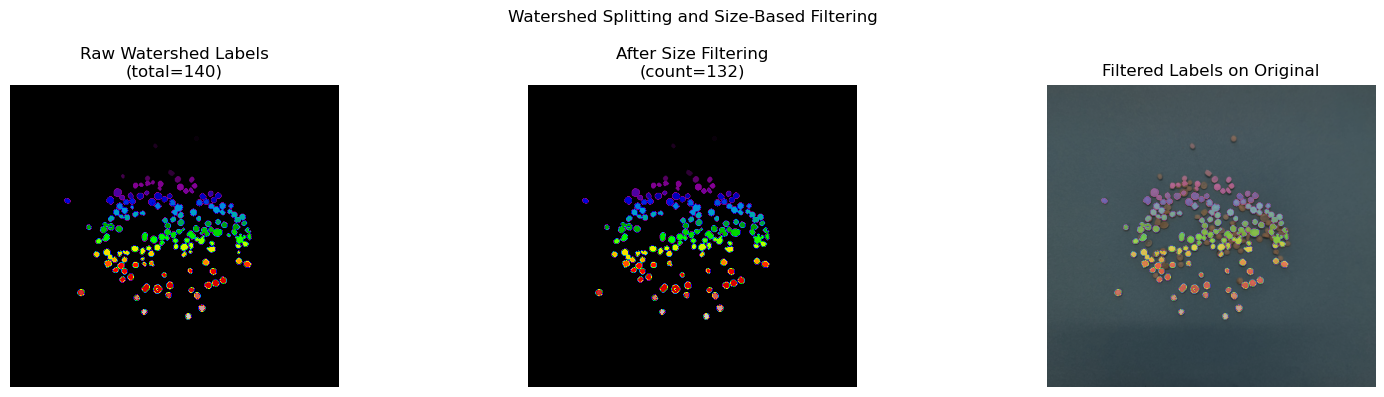

In [73]:
if __name__ == "__main__":
    IMG_PATH = "new_cropped/180_nurdles.png"  # adjust

    visualize_watershed_and_filtering(IMG_PATH)
  